In [1]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
from __future__ import division, unicode_literals, with_statement, print_function
from contextlib import closing

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import statsmodels.api as sm
# 中樂透的資料統計, 看Literacy, Wealth, Region是否跟中樂透有線性關係
df = sm.datasets.get_rdataset("Guerry", "HistData").data
cols = ['Department', 'Lottery', 'Literacy', 'Wealth', 'Region']
df = df[cols].dropna()
df

,Department,Lottery,Literacy,Wealth,Region
0,Ain,41,37,73,E
1,Aisne,38,51,22,N
2,Allier,66,13,61,C
3,Basses-Alpes,80,46,76,E
4,Hautes-Alpes,79,69,83,E
5,Ardeche,70,27,84,S
6,Ardennes,31,67,33,N
7,Ariege,75,18,72,S
8,Aube,28,59,14,E
9,Aude,50,34,17,S


## ols回歸一些output的意義
### F test、T test
```
回歸模型可以用F檢定去測試
    回歸公式 Y = b0 + b1X1 + b2X2 + ...  + bnXn
    - H0(虛無假設): 是你的回歸公式 Y = b0 + b1X1 + b2X2 + ...  + bnXn, 你的X1 ~ Xn全都0 => 
                   那就是Y = b0, 英文叫做intercept-only model
    - H1: 當然就是H0的否定, bj != 0 {1 <= j <= n}
然後檢驗是否要推翻(Reject)H0, 算出F value在去查表(95%信賴區間), 參考 http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm

- df_model: 模組自由度, (自變數個數 - 1)
- df_resid: 殘差自由度, (樣本個數 - 變數個數 - 1) 
   statsmodels的ssr跟我查到的相反, 他根本是sse, 是[迴歸結果跟實際資料距離的sum of square]
   ssr理論應該要是 [迴歸結果跟實際資料mean距離的sum of square]
   所以這裡我寫的跟 statsmodels 不一樣

- ssr = sst - sse
- rsquare = 1 - sse / sst = ssr / sst
- fvalue(F檢定統計值) = (ssr / df_model) / (sse / df_resid) => 也寫作 MSR/MSE
- tvalue(T檢定統計值) = (mean - 給定的mean) / (標準差/sqrt(樣本個數))


f test用在regression是MSR/MSE, 但是用在多組樣本的話則是 MSB/MSW, MSB是所謂的組間平方合, MSW是組內平方合
(公式看這裡 
http://belleaya.pixnet.net/blog/post/30754486-%5B%E6%95%99%E5%AD%B8%5D-%5B%E7%B5%B1%E8%A8%88%5D-anova%E8%AE%8A%E7%95%B0%E6%95%B8%E5%88%86%E6%9E%90-%E5%B0%8F%E7%AD%86%E8%A8%98),
, f test 目的確實是討論變異數的差別, 但多一個名詞是怎樣, 取多一點名字以為就會比較厲害了嗎?
結論是
1. f test 在討論不同組資料變異數的差異, H0是變異數沒什麼差, 然後推翻他
2. t test 在討論平均數是否為你給定的某個value, H0是平均數跟你定的一樣, 然後推翻他
3. AIC, BIC 是迴規模型選擇的指標, 兩個都越小越好, 大小是用比較的 (不是說小於某個數字就是小, 沒有表可以查)
 - AIC: https://zh.wikipedia.org/wiki/%E8%B5%A4%E6%B1%A0%E4%BF%A1%E6%81%AF%E9%87%8F%E5%87%86%E5%88%99
 - BIC: https://en.wikipedia.org/wiki/Bayesian_information_criterion
```

### Log-Likelihood
```
每個不同的迴歸估計方式, 有著不同的MLE(maximum likelihood estimate), 
OLS, WLS 的公式都不一樣, 參考[維基](https://zh.wikipedia.org/wiki/%E6%9C%80%E5%A4%A7%E4%BC%BC%E7%84%B6%E4%BC%B0%E8%AE%A1)講的比較詳細
OLS的 MLE function: http://www.mayin.org/ajayshah/KB/R/documents/mle/ols-lf.pdf
```

### Jarque-Bera檢定 => 檢定是否模型的殘差符合常態分配
```
H0: 變數是常態分配
其實看summary的Prob(JB)就好, < 0.05就是拒絕H0 => 不符合常態分配
JB的公式參考[這裡](http://yaya.it.cycu.edu.tw/course/PPT/ch02-PPT-%E5%81%87%E8%A8%AD%E6%AA%A2%E5%AE%9A%E8%88%87%E6%87%89%E7%94%A8.pdf)
```

In [5]:
from patsy import dmatrices, dmatrix
# patsy.dmatrices 版本最好更新到 0.4.1
# dmatrices用意在可以幫你類別變數轉成數字
y, X = dmatrices('Lottery ~ Literacy + Wealth + Region', data=df, return_type='dataframe')
print(X[:5])

mod = sm.OLS(y, X)    # Describe model
res = mod.fit()       # Fit model
print(res.summary())   # Summarize model

# (F-statistic, P-value)
# sm.stats.linear_rainbow(res)

# F test: 其實res.summary()報表已經把 fvalue f_pvalue, 有算出來, 若要個別 F test, 則可以用res.f_test 
# 看下面的formula用法可以看出f test的虛無假設 => 認為所有自變數的係數都是0
# print(res.f_test("Region[T.E] = Region[T.N] = Region[T.S] = Region[T.W] = Literacy = Wealth = 0"))

   Intercept  Region[T.E]  Region[T.N]  Region[T.S]  Region[T.W]  Literacy  \
0          1            1            0            0            0        37   
1          1            0            1            0            0        51   
2          1            0            0            0            0        13   
3          1            1            0            0            0        46   
4          1            1            0            0            0        69   

   Wealth  
0      73  
1      22  
2      61  
3      76  
4      83  
                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Mon, 26 Sep 2016   Prob (F-statistic):           1.07e-05
Time:                        11:49:05   Log-Likelihood:         

Help on function wls_prediction_std in module statsmodels.sandbox.regression.predstd:

wls_prediction_std(res, exog=None, weights=None, alpha=0.05)
    calculate standard deviation and confidence interval for prediction
    
    applies to WLS and OLS, not to general GLS,
    that is independently but not identically distributed observations
    
    Parameters
    ----------
    res : regression result instance
        results of WLS or OLS regression required attributes see notes
    exog : array_like (optional)
        exogenous variables for points to predict
    weights : scalar or array_like (optional)
        weights as defined for WLS (inverse of variance of observation)
    alpha : float (default: alpha = 0.05)
        confidence level for two-sided hypothesis
    
    Returns
    -------
    predstd : array_like, 1d
        standard error of prediction
        same length as rows of exog
    interval_l, interval_u : array_like
        lower und upper confidence bounds
    
  

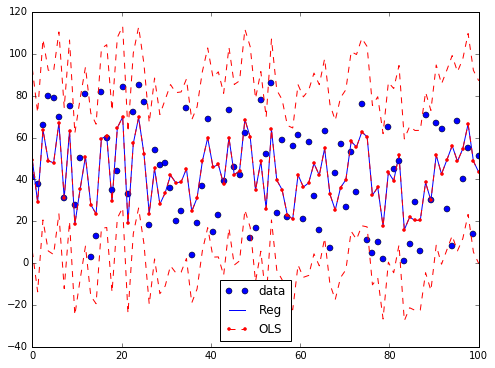

In [158]:
# 畫出來亂七八糟..., model pvalue = 1.07e-05 卻非常低, 就是很好的意思, 這真的算準嗎?
from matplotlib import pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
help(wls_prediction_std)
# prstd: 預測標準差
# iv_l: 信賴區間lower bound
# iv_u: 信賴區間upper bound
prstd, iv_l, iv_u = wls_prediction_std(res)

x = np.linspace(0, 100, len(y))
yReg = np.dot(X, res.params)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y.Lottery.values, 'o', label="data")
ax.plot(x, yReg, 'b-', label="Reg")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best')

In [16]:
# 官網範例, 產生sin圖型(非線性), 看能不能用 ols 產生好的regression模型
nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x-5)**2, np.ones(nsample)))
# 係數, 為什麼這樣訂也沒說
beta = [0.5, 0.5, -0.02, 5.]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)
print(X)
print(y)

[[  0.00000000e+00   0.00000000e+00   2.50000000e+01   1.00000000e+00]
 [  4.08163265e-01   3.96924149e-01   2.10849646e+01   1.00000000e+00]
 [  8.16326531e-01   7.28634783e-01   1.75031237e+01   1.00000000e+00]
 [  1.22448980e+00   9.40632785e-01   1.42544773e+01   1.00000000e+00]
 [  1.63265306e+00   9.98087482e-01   1.13390254e+01   1.00000000e+00]
 [  2.04081633e+00   8.91559230e-01   8.75676801e+00   1.00000000e+00]
 [  2.44897959e+00   6.38550320e-01   6.50770512e+00   1.00000000e+00]
 [  2.85714286e+00   2.80629400e-01   4.59183673e+00   1.00000000e+00]
 [  3.26530612e+00  -1.23398137e-01   3.00916285e+00   1.00000000e+00]
 [  3.67346939e+00  -5.07151709e-01   1.75968347e+00   1.00000000e+00]
 [  4.08163265e+00  -8.07581691e-01   8.43398584e-01   1.00000000e+00]
 [  4.48979592e+00  -9.75328286e-01   2.60308205e-01   1.00000000e+00]
 [  4.89795918e+00  -9.82831204e-01   1.04123282e-02   1.00000000e+00]
 [  5.30612245e+00  -8.28857736e-01   9.37109538e-02   1.00000000e+00]
 [  5.

In [17]:
# 看 Prob (F-statistic) [就是pvalue] 2.10e-26 那麼低 , 看來這個模型被預測的不錯
sinModel = sm.OLS(y, X)
sinRes = sinModel.fit()
print(sinRes.summary())
sinRes.summary2()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     200.2
Date:                Wed, 21 Sep 2016   Prob (F-statistic):           2.10e-26
Time:                        11:03:22   Log-Likelihood:                -36.868
No. Observations:                  50   AIC:                             81.74
Df Residuals:                      46   BIC:                             89.38
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.4919      0.028     17.744      0.0

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.924   
Dependent Variable: y                AIC:                81.7363 
Date:               2016-09-21 11:03 BIC:                89.3844 
No. Observations:   50               Log-Likelihood:     -36.868 
Df Model:           3                F-statistic:        200.2   
Df Residuals:       46               Prob (F-statistic): 2.10e-26
R-squared:          0.929            Scale:              0.27810 
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.4919     0.0277   17.7438   0.0000    0.4361    0.5477
x2         0.6813     0.1090    6.2516   0.0000    0.4619    0.9006
x3        -0.0195     0.0024   -8.0139   0.0000   -0.0244   -0.0146
const      5.2138     0.1797   29.0070   0.0000    4.8520    5.5756
-----------------------------------------------------------------
Omnibus:               2.671        Durbin-Watson:          2.149
Prob(Omnibus):         0.263        Jarque-Bera (JB):       2.515
Skew:                  -0.528       Prob(JB):               0.284
Kurtosis:              2.695        Condition No.:          221  
=================================================================

"""

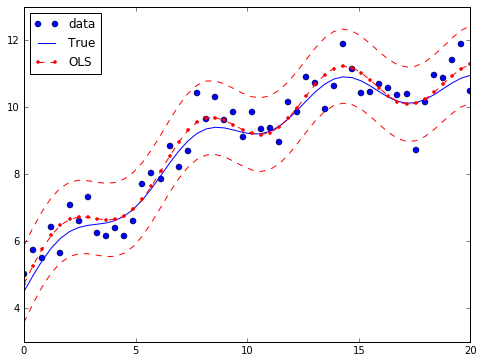

In [18]:
prstd, iv_l, iv_u = wls_prediction_std(sinRes)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'o', label="data")
ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, sinRes.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best')

In [21]:
# 共線性, 官網描述
"""
Multicollinearity
The Longley dataset is well known to have high multicollinearity. 
That is, the exogenous predictors are highly correlated. 
This is problematic because it can affect the stability of our coefficient estimates as we make minor changes to model specification.

共線性是說自變數之間有可推導關係, 檢測的方式, 目前查到VIF, Variance inflation factor, 這邊也不在追究下去~
"""
from statsmodels.datasets.longley import load_pandas
y = load_pandas().endog
X = load_pandas().exog
X = sm.add_constant(X)
print(y)
X

0     60323
1     61122
2     60171
3     61187
4     63221
5     63639
6     64989
7     63761
8     66019
9     67857
10    68169
11    66513
12    68655
13    69564
14    69331
15    70551
Name: TOTEMP, dtype: float64


,const,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,1,83.0,234289,2356,1590,107608,1947
1,1,88.5,259426,2325,1456,108632,1948
2,1,88.2,258054,3682,1616,109773,1949
3,1,89.5,284599,3351,1650,110929,1950
4,1,96.2,328975,2099,3099,112075,1951
5,1,98.1,346999,1932,3594,113270,1952
6,1,99.0,365385,1870,3547,115094,1953
7,1,100.0,363112,3578,3350,116219,1954
8,1,101.2,397469,2904,3048,117388,1955
9,1,104.6,419180,2822,2857,118734,1956


In [22]:
# summary出現condition number太大的警告, 說共線性太強
# 官網描述: condition number破20就太高
"""
Condition number
One way to assess multicollinearity is to compute the condition number. 
Values over 20 are worrisome (see Greene 4.9). The first step is to normalize the independent variables to have unit length:
"""
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Wed, 21 Sep 2016   Prob (F-statistic):           4.98e-10
Time:                        11:17:03   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -3.482e+06    8.9e+05     -3.911      0.0

D:\Gary\WinPython\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\scipy\stats\stats.py:1285: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [40]:
norm_x = X.values
for i, name in enumerate(X):
    if name == "const":
        continue
    norm_x[:,i] = X[name]/np.linalg.norm(X[name])
# norm_x.shape
norm_xtx = np.dot(norm_x.T, norm_x)
print(norm_x.shape)

print(norm_xtx.shape)
pd.DataFrame(data=norm_xtx)

(16L, 7L)


,0,1,2,3,4,5,6
0,16.000000,3.979046,3.882181,3.848501,3.872704,3.993436,3.999989
1,3.979046,1.000000,0.989881,0.974380,0.974994,0.998861,0.994998
2,3.882181,0.989881,1.000000,0.973472,0.966576,0.982626,0.971108
3,3.848501,0.974380,0.973472,1.000000,0.919402,0.971264,0.962552
4,3.872704,0.974994,0.966576,0.919402,1.000000,0.971810,0.968419
5,3.993436,0.998861,0.982626,0.971264,0.971810,1.000000,0.998491
6,3.999989,0.994998,0.971108,0.962552,0.968419,0.998491,1.000000


這裡闡述了cond number的求法, 不需要下去追究為什麼了, 當作公式背吧~
方陣的eigenvalue, 回去複習線性代數 囧

A為方陣

$Ax = \lambda{x}\space 存在eigenvalue\space\lambda, eigenvector\space x 使得此公式成立$

In [102]:
from IPython.display import display, Math, Latex
eigs = np.linalg.eigvals(norm_xtx)
print(eigs)
condition_number = np.sqrt(eigs.max() / eigs.min())
print(condition_number)

A為方陣


<IPython.core.display.Math object>

[  2.18130673e+01   1.00812550e-01   7.52539450e-02   1.07260763e-02
   1.32052679e-04   6.89624479e-09   8.05181271e-06]
56240.8706763


In [8]:
np.array([[1, 3, 2], [4 ,5, 6]]).argmax()

5